<a href="https://colab.research.google.com/github/potohodnica/magistrska/blob/main/GALAH_load_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import os, urllib
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import glob
import pandas as pd
from functools import reduce

In [2]:
# Adjust directory you want to work in
working_directory = '/content/'
os.chdir(working_directory)

# Choose if you want to plot the normalised or reduced spectra
normalised = False

# Choose if you want to save the plot as PNG file
savefig = True

In [67]:
# Put the sobject_ids here
sobject_ids = [
    170418003701205,
    170603008301249, 
    170604002101031
]

In [66]:
def download_spectra(sobject_id,ccd):
    """
    Try to download the specfici spectrum from Datacentral
    """

    ccd_dict = {
      1: "B",
      2: "G",
      3: "R",
      4: "I"
      }
   
    try:
      link = 'https://datacentral.org.au/vo/slink/links?ID=' + str(sobject_id) + '&DR=galah_dr3&IDX=0&FILT=' + ccd_dict[ccd] + '&RESPONSEFORMAT=fits'
      urllib.request.urlretrieve(link, '/content/'+str(sobject_id)+str(ccd)+'.fits')
      return [working_directory+str(sobject_id)+str(ccd)+'.fits']
    except:
      print('FITS '+str(sobject_id)+str(ccd)+' not available')
      return []

In [47]:
def read_spectra(sobject_id, tutorial=True):
    """
    Read in all available CCDs and give back a dictionary
    Download them if not already in working directory
    """
    
    # Check if FITS files already available in working directory
    fits_files = [[], [], [], []]
    for each_ccd in [1,2,3,4]:
        fits_files[each_ccd-1] = glob.glob(working_directory+str(sobject_id)+str(each_ccd)+'.fits')
    # If not already available, try to download
    for each_ccd in [1,2,3,4]:
        if fits_files[each_ccd-1] == []:
            fits_files[each_ccd-1] = download_spectra(sobject_id,each_ccd)
    
    spectrum = dict()

    for each_ccd in [1,2,3,4]:
        if fits_files[each_ccd-1]!=[]:
            fits = pyfits.open(fits_files[each_ccd-1][0])

            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            if len(fits) == 5:
              ext1 = True
              ext4 = True
            elif len(fits) == 2:
              ext1 = True
              ext4 = False
              print('Normalised spectrum missing in',str(each_ccd),'ccd.')
            else:
              ext1 = False
              ext4 = False
              print('Relative error spectrum and normalised spectrum missing in',str(each_ccd),'ccd.')

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]
            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            if ext4:
              # Extract wavelength grid for the normalised spectrum

              start_wavelength = fits[4].header["CRVAL1"]
              dispersion       = fits[4].header["CDELT1"]
              nr_pixels        = fits[4].header["NAXIS1"]
              reference_pixel  = fits[4].header["CRPIX1"]
              if reference_pixel == 0:
                reference_pixel=1
              spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)

            # Extract flux and flux error of reduced spectrum
            # Added byteswap for Pandas use ----> https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data).byteswap().newbyteorder()
            if ext1:
              spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            if ext4 and ext1: 
              # Extract flux and flux error of normalised spectrum
              spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
              if each_ccd != 4:
                 spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
              else:
                 # for normalised error of CCD4, only used appropriate parts of error spectrum
                 spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    if ext4:
       spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
       spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    if ext1:
       spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    if ext1 and ext4:
       spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    
   
    return spectrum

In [39]:
def plot_spectra(sobject_id, normalised=True, savefig=False):
    """
    Plot the spectra in a 4x1 panel figure
    """
    f, ccds = plt.subplots(4,1,figsize=(11.69, 8.27))
    kwargs_sob = dict(c = 'k', lw=0.5, label='Flux', rasterized=True)
    kwargs_error_spectrum = dict(color = 'grey', label='Flux error', rasterized=True)

    for each_ccd in [1, 2, 3, 4]:
        ax=ccds[each_ccd-1]
        
        if normalised:
          red_norm = 'norm'
        else:
          red_norm = 'red'
        
        # Overplot observed spectrum a bit thicker
        ax.plot(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_sob
            )
        
        if normalised:
            ax.set_ylabel('Flux [norm.]')
            ax.set_ylim(-0.1,1.3)
        else:
            ax.set_ylabel('Counts')
            try:
              ax.set_ylim(0,1.1*np.percentile(spectrum['sob_red_'+str(each_ccd)],q=95))
            except:
              pass
        if each_ccd == 1:
            ax.set_title(str(sobject_id))
            ax.set_xlim(4710,4905)
        if each_ccd == 2:
            ax.set_xlim(5645,5877.5)
        if each_ccd == 3:
            ax.set_xlim(6472.5,6740)
        if each_ccd == 4:
            ax.set_xlim(7580,7890)
            ax.set_xlabel('Wavelength [Å]')
        if each_ccd == 4:
            ax.legend(loc='lower left')              
   
    plt.tight_layout()
    if savefig:
        plt.savefig(working_directory+str(sobject_id)+'_'+red_norm+'.png',bbox_inches='tight',dpi=200)
    plt.show()
    plt.close()
    
    return f

FITS 1704180037012052 not available
Relative error spectrum and normalised spectrum missing in 1 ccd.
Relative error spectrum and normalised spectrum missing in 3 ccd.
Relative error spectrum and normalised spectrum missing in 4 ccd.


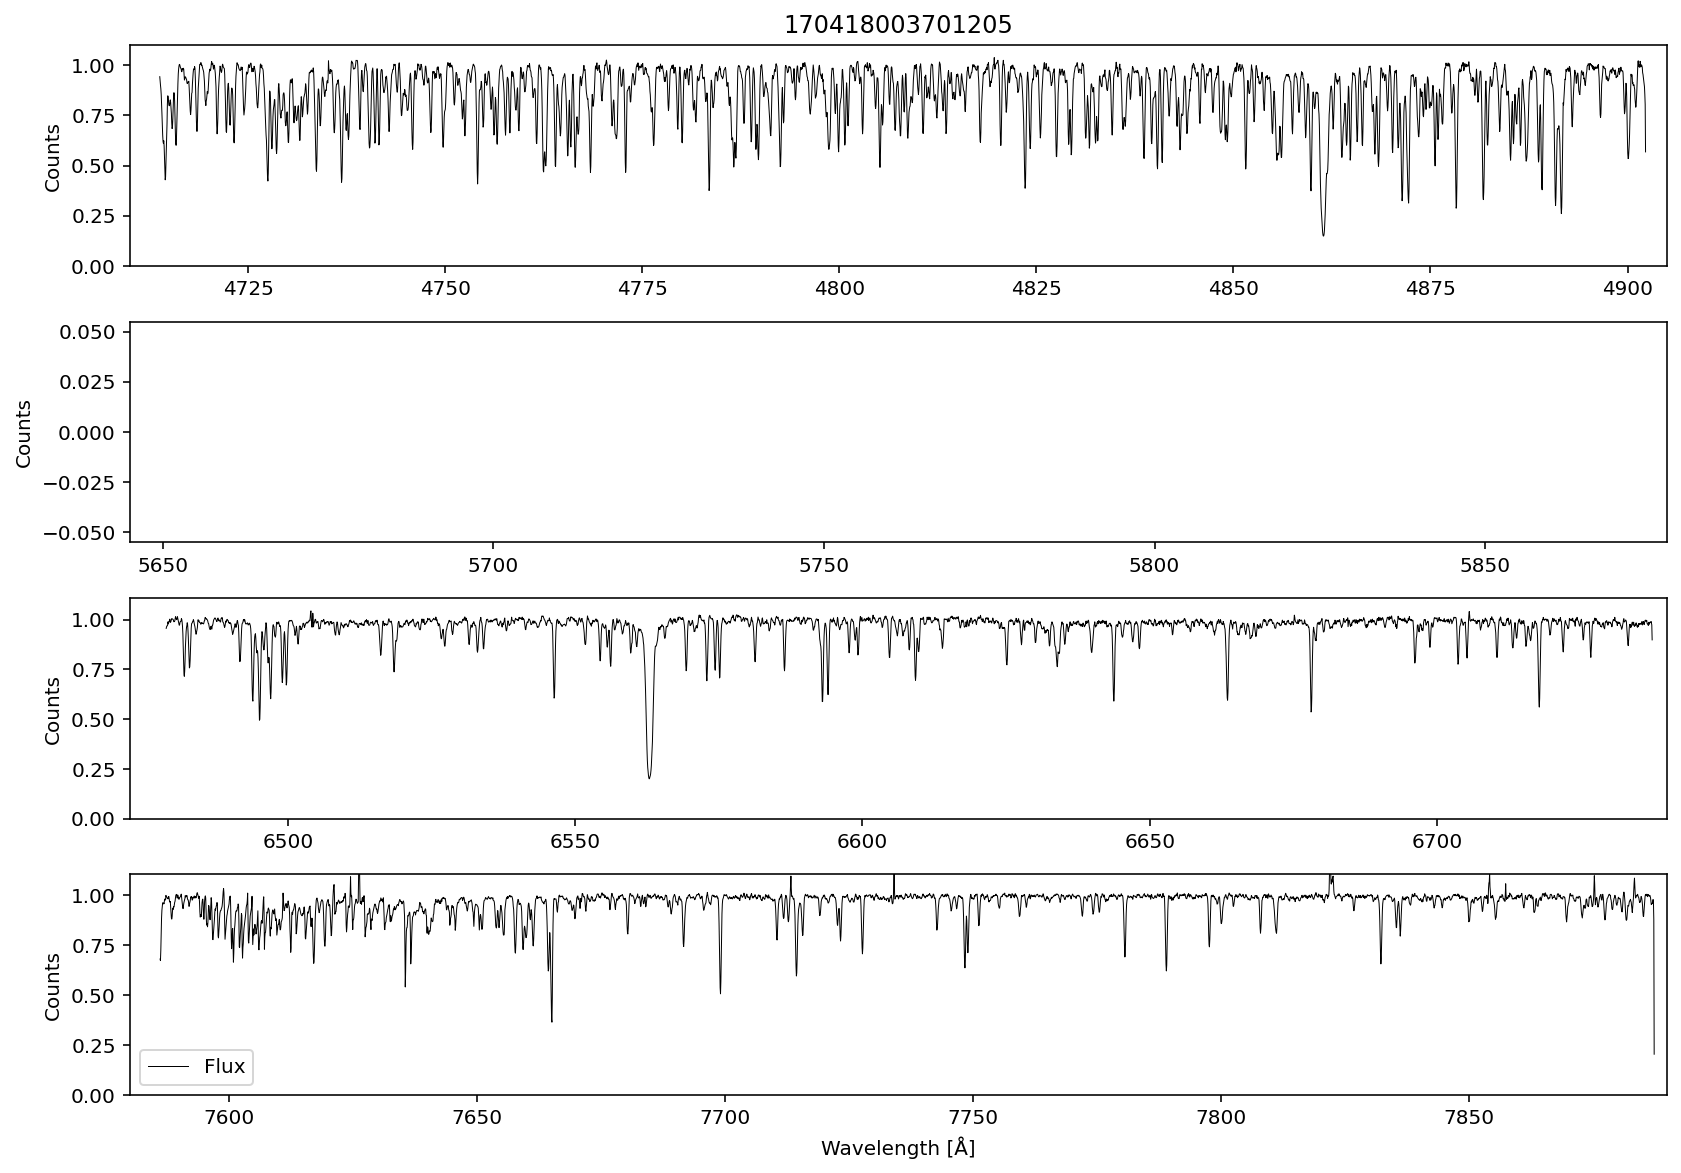

FITS 1706030083012492 not available
Relative error spectrum and normalised spectrum missing in 1 ccd.
Relative error spectrum and normalised spectrum missing in 3 ccd.
Relative error spectrum and normalised spectrum missing in 4 ccd.


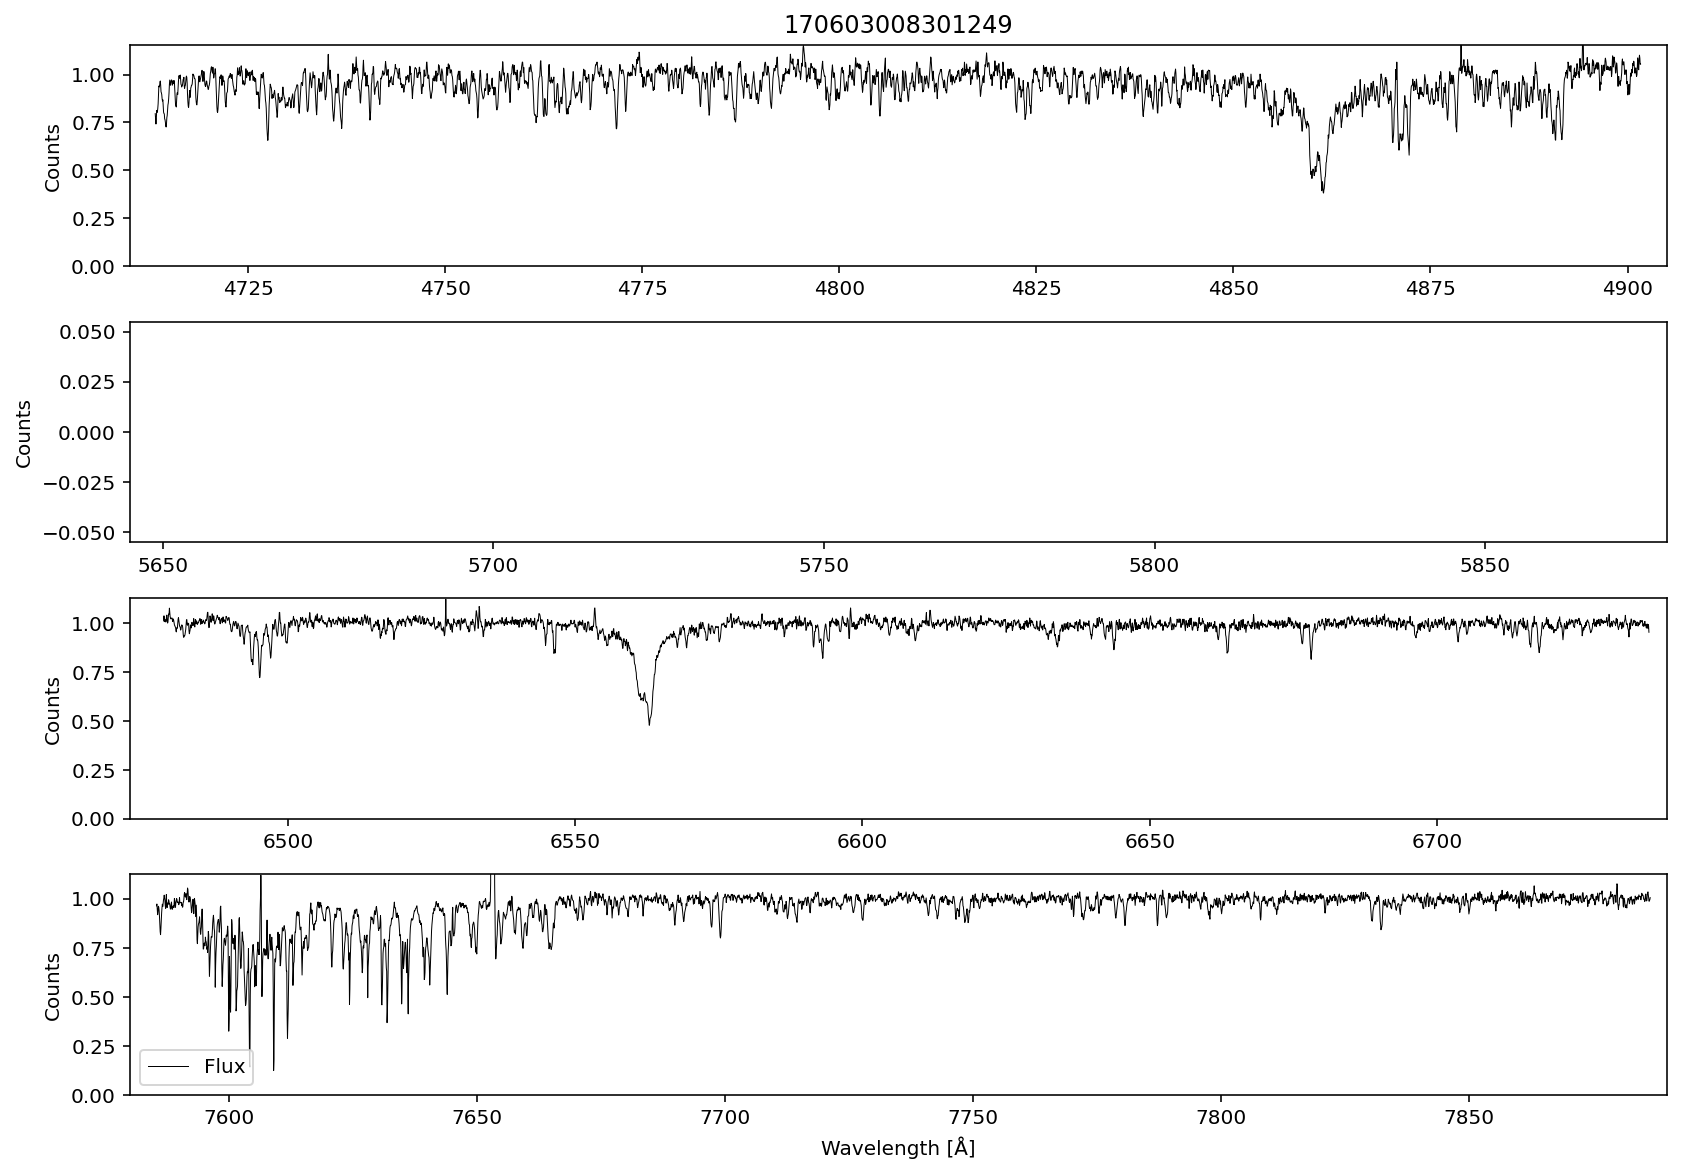

FITS 1706040021010312 not available
Relative error spectrum and normalised spectrum missing in 1 ccd.
Relative error spectrum and normalised spectrum missing in 3 ccd.
Relative error spectrum and normalised spectrum missing in 4 ccd.


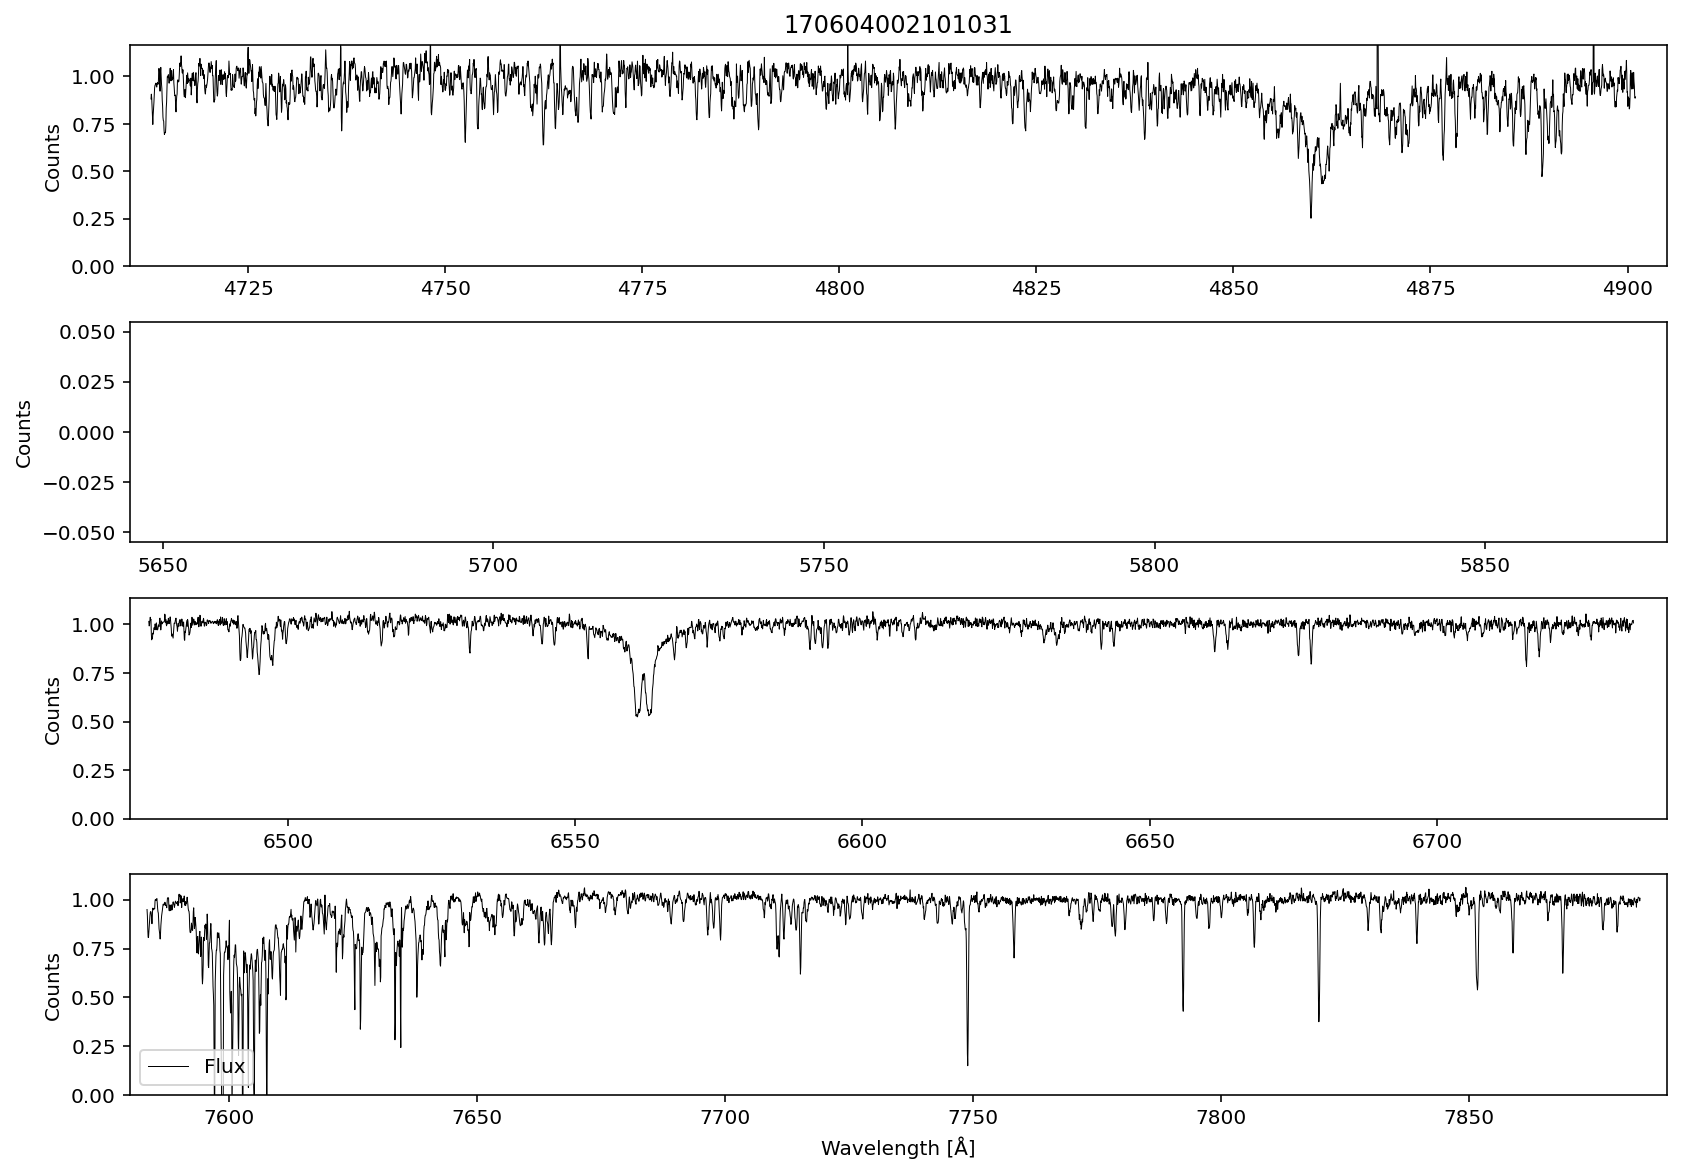

In [71]:
spectrum1_dfs = []
spectrum2_dfs = []
spectrum3_dfs = []
spectrum4_dfs = []

for sobject_id in sobject_ids:
    spectrum = read_spectra(sobject_id)

    spectrum1_dfs.append(pd.DataFrame({'wave_red': spectrum['wave_red_1'], str(sobject_id) + '1': spectrum['sob_red_1']}))
    spectrum2_dfs.append(pd.DataFrame({'wave_red': spectrum['wave_red_2'], str(sobject_id) + '2': spectrum['sob_red_2']}))
    spectrum3_dfs.append(pd.DataFrame({'wave_red': spectrum['wave_red_3'], str(sobject_id) + '3': spectrum['sob_red_3']}))
    spectrum4_dfs.append(pd.DataFrame({'wave_red': spectrum['wave_red_4'], str(sobject_id) + '4': spectrum['sob_red_4']}))
    f = plot_spectra(sobject_id, normalised=normalised, savefig=savefig)

df_merged1 = reduce(lambda  left,right: pd.merge(left,right,on=['wave_red'], how='outer'), spectrum1_dfs)
df_merged2 = reduce(lambda  left,right: pd.merge(left,right,on=['wave_red'], how='outer'), spectrum2_dfs)
df_merged3 = reduce(lambda  left,right: pd.merge(left,right,on=['wave_red'], how='outer'), spectrum3_dfs)
df_merged4 = reduce(lambda  left,right: pd.merge(left,right,on=['wave_red'], how='outer'), spectrum4_dfs)

In [72]:
print(df_merged1)

          wave_red  1704180037012051  1706030083012491  1706040021010311
0      4713.805086          0.942937               NaN               NaN
1      4713.851113          0.917947               NaN               NaN
2      4713.897140          0.900018               NaN               NaN
3      4713.943167          0.881841               NaN               NaN
4      4713.989194          0.852907               NaN               NaN
...            ...               ...               ...               ...
12283  4900.822318               NaN               NaN          0.973839
12284  4900.868304               NaN               NaN          0.948766
12285  4900.914290               NaN               NaN          0.891141
12286  4900.960277               NaN               NaN          0.885062
12287  4901.006263               NaN               NaN          0.891727

[12288 rows x 4 columns]


In [73]:
print(df_merged2)

Empty DataFrame
Columns: [1704180037012052, 1706030083012492, wave_red, 1706040021010312]
Index: []


In [74]:
print(df_merged3)

          wave_red  1704180037012053  1706030083012493  1706040021010313
0      6478.834844          0.955513               NaN               NaN
1      6478.897992          0.963117               NaN               NaN
2      6478.961140          0.967949               NaN               NaN
3      6479.024289          0.968265               NaN               NaN
4      6479.087437          0.973265               NaN               NaN
...            ...               ...               ...               ...
12283  6733.925600               NaN               NaN          1.005737
12284  6733.988693               NaN               NaN          1.016951
12285  6734.051787               NaN               NaN          1.016931
12286  6734.114880               NaN               NaN          1.020477
12287  6734.177974               NaN               NaN          1.007154

[12288 rows x 4 columns]


In [75]:
print(df_merged4)

          wave_red  1704180037012054  1706030083012494  1706040021010314
0      7586.112764          0.681639               NaN               NaN
1      7586.186345          0.673634               NaN               NaN
2      7586.259926          0.725054               NaN               NaN
3      7586.333507          0.809376               NaN               NaN
4      7586.407088          0.886160               NaN               NaN
...            ...               ...               ...               ...
12283  7884.289539               NaN               NaN          1.011552
12284  7884.363068               NaN               NaN          1.009195
12285  7884.436598               NaN               NaN          1.008171
12286  7884.510127               NaN               NaN          0.993569
12287  7884.583657               NaN               NaN          1.006857

[12288 rows x 4 columns]
